In [2]:
# =========================================
# Backtest: Boosting + MultiTask TCN (Walk-forward)
# =========================================
import json, joblib
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn

from sklearn.metrics import accuracy_score, f1_score

# -----------------------
# 0) PATHS
# -----------------------
BASE_DIR = Path(
    "/Users/thanaporn/Desktop/EURO_H1_AI/prepared_datasets/boosting_dl_multitask"
)
MODEL_DIR = BASE_DIR / "trained_models_multitask"
META_PATH = BASE_DIR / "eurusd_multitask_meta.json"
DF_ALL_PATH = BASE_DIR / "eurusd_df_all_full.csv"

# -----------------------
# 1) Load meta
# -----------------------
with open(META_PATH, "r", encoding="utf-8") as f:
    meta = json.load(f)

feature_cols = meta["feature_cols"]
seq_len = meta["seq_len"]
horizon = meta["horizon"]
targets_boosting = meta["targets_boosting"]  # ["tgt_high_break",...]
targets_dl = meta["targets_dl"]  # same list

print("Features:", len(feature_cols))
print("Targets:", targets_dl)

# -----------------------
# 2) Load Boosting models (classification)
# -----------------------
boost_models = {
    name: joblib.load(MODEL_DIR / f"lgb_{name}.pkl") for name in targets_boosting
}


def predict_boost_np(x_np_2d: np.ndarray):
    """
    x_np_2d: [N, F]
    return:
      prob_dict[name]  -> prob (binary: prob of 1, multiclass: prob matrix)
      pred_dict[name]  -> label
    """
    prob_dict = {}
    pred_dict = {}

    for name, m in boost_models.items():
        if name == "tgt_candle_class":
            prob = m.predict_proba(x_np_2d)  # [N,3]
            label = np.argmax(prob, axis=1)
        else:
            prob_full = m.predict_proba(x_np_2d)  # [N,2]
            prob = prob_full[:, 1]
            label = (prob >= 0.5).astype(int)

        prob_dict[name] = prob
        pred_dict[name] = label

    return prob_dict, pred_dict


# -----------------------
# 3) Load DL model + scaler (MultiTask TCN)
# -----------------------
class TCNBlock(nn.Module):
    def __init__(self, c_in, c_out, k=3, dilation=1, dropout=0.1):
        super().__init__()
        pad = (k - 1) * dilation
        self.net = nn.Sequential(
            nn.Conv1d(c_in, c_out, k, padding=pad, dilation=dilation),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(c_out, c_out, k, padding=pad, dilation=dilation),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.down = nn.Conv1d(c_in, c_out, 1) if c_in != c_out else nn.Identity()

    def forward(self, x):
        y = self.net(x)
        y = y[..., : x.size(-1)]
        return y + self.down(x)


class MultiTaskTCN(nn.Module):
    def __init__(self, n_features: int, channels=(64, 64, 64)):
        super().__init__()
        layers = []
        c_in = n_features
        for i, c_out in enumerate(channels):
            layers.append(TCNBlock(c_in, c_out, dilation=2**i))
            c_in = c_out
        self.tcn = nn.Sequential(*layers)

        hidden_dim = channels[-1]
        self.head_break = nn.Linear(hidden_dim, 2)  # 2 logits (high/low)
        self.head_vol = nn.Linear(hidden_dim, 1)  # 1 logit
        self.head_candle = nn.Linear(hidden_dim, 3)  # 3 logits

    def forward(self, x):
        # x: [B,T,F] -> [B,F,T]
        x = x.transpose(1, 2)
        z = self.tcn(x)
        z_last = z[..., -1]

        logits_break = self.head_break(z_last)  # [B,2]
        logits_vol = self.head_vol(z_last).squeeze(-1)  # [B]
        logits_candle = self.head_candle(z_last)  # [B,3]

        return logits_break, logits_vol, logits_candle


device = (
    "cuda"
    if torch.cuda.is_available()
    else ("mps" if torch.backends.mps.is_available() else "cpu")
)
print("Device:", device)

model = MultiTaskTCN(n_features=len(feature_cols)).to(device)
model.load_state_dict(torch.load(MODEL_DIR / "tcn_multitask.pth", map_location=device))
model.eval()

scaler = joblib.load(MODEL_DIR / "dl_scaler.pkl")

# -----------------------
# 4) Load df_all เต็ม (ฟีเจอร์ + target พร้อมใช้)
# -----------------------
df_all = pd.read_csv(DF_ALL_PATH, index_col=0, parse_dates=True)
df_all = df_all.sort_index()

# ต้องมี feature_cols + targets_dl อยู่ใน df_all
missing_feat = [c for c in feature_cols if c not in df_all.columns]
missing_tgt = [c for c in targets_dl if c not in df_all.columns]
if missing_feat or missing_tgt:
    raise KeyError(f"Missing columns. feat={missing_feat}, tgt={missing_tgt}")

print("df_all shape:", df_all.shape)

# -----------------------
# 5) Walk-forward backtest (ใช้ทั้ง Boosting + DL)
# -----------------------
records = []

start_i = seq_len - 1  # index เริ่มต้น (ต้องมี seq_len แท่งย้อนหลัง)
end_i = len(df_all) - 1  # สุดท้าย = แท่งที่มี target พร้อมแล้ว

for i in range(start_i, end_i + 1):
    # sequence features (ย้อนหลัง seq_len แท่ง)
    df_seq = df_all.iloc[i - seq_len + 1 : i + 1]
    x_seq = df_seq[feature_cols].values.astype(np.float32)  # [T,F]

    # tabular feature = แท่งสุดท้าย (เหมือนตอนเทรน boosting)
    x_tab = df_seq.iloc[-1][feature_cols].values.astype(np.float32).reshape(1, -1)

    # ----- Boosting preds -----
    boost_prob, boost_pred = predict_boost_np(x_tab)

    # ----- DL preds -----
    x_seq_s = scaler.transform(x_seq).reshape(1, seq_len, len(feature_cols))
    x_seq_s = torch.tensor(x_seq_s, dtype=torch.float32).to(device)

    with torch.no_grad():
        logits_break, logits_vol, logits_candle = model(x_seq_s)

    logits_break = logits_break.cpu().numpy()[0]  # [2]
    logits_vol = logits_vol.cpu().numpy()[0]  # []
    logits_candle = logits_candle.cpu().numpy()[0]  # [3]

    # binary prob
    prob_break_high = 1.0 / (1.0 + np.exp(-logits_break[0]))
    prob_break_low = 1.0 / (1.0 + np.exp(-logits_break[1]))
    prob_vol_high = 1.0 / (1.0 + np.exp(-logits_vol))

    # multiclass prob
    exp_candle = np.exp(logits_candle - logits_candle.max())
    prob_candle = exp_candle / exp_candle.sum()

    pred_break_high = int(prob_break_high >= 0.5)
    pred_break_low = int(prob_break_low >= 0.5)
    pred_vol_high = int(prob_vol_high >= 0.5)
    pred_candle = int(np.argmax(prob_candle))

    # ----- true labels ณ แท่ง i (แท่งที่เราทำนาย) -----
    row_true = df_all.iloc[i]
    true_high_break = int(row_true["tgt_high_break"])
    true_low_break = int(row_true["tgt_low_break"])
    true_vol_high = int(row_true["tgt_vol_high"])
    true_candle = int(row_true["tgt_candle_class"])

    date_t = df_all.index[i]

    records.append(
        {
            "Time": date_t,
            # true
            "tgt_high_break_true": true_high_break,
            "tgt_low_break_true": true_low_break,
            "tgt_vol_high_true": true_vol_high,
            "tgt_candle_true": true_candle,
            # Boosting preds
            "boost_high_break_pred": int(boost_pred["tgt_high_break"][0]),
            "boost_low_break_pred": int(boost_pred["tgt_low_break"][0]),
            "boost_vol_high_pred": int(boost_pred["tgt_vol_high"][0]),
            "boost_candle_pred": int(boost_pred["tgt_candle_class"][0]),
            # DL preds
            "dl_high_break_pred": pred_break_high,
            "dl_low_break_pred": pred_break_low,
            "dl_vol_high_pred": pred_vol_high,
            "dl_candle_pred": pred_candle,
            # prob (optional สำหรับวางกลยุทธ์)
            "dl_high_break_prob": prob_break_high,
            "dl_low_break_prob": prob_break_low,
            "dl_vol_high_prob": prob_vol_high,
            "dl_candle_p0": prob_candle[0],
            "dl_candle_p1": prob_candle[1],
            "dl_candle_p2": prob_candle[2],
        }
    )

bt = pd.DataFrame(records).set_index("Time").sort_index()
print("Backtest rows:", len(bt))
print(bt.head())

Features: 24
Targets: ['tgt_high_break', 'tgt_low_break', 'tgt_vol_high', 'tgt_candle_class']
Device: mps
df_all shape: (2960, 36)


/var/folders/yv/fzq7m78s20b8hp75zqwdn8bw0000gn/T/ipykernel_20273/3680925040.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_DIR 

Backtest rows: 2910
            tgt_high_break_true  tgt_low_break_true  tgt_vol_high_true  \
Time                                                                     
2010-04-15                    0                   1                  0   
2010-04-16                    0                   1                  0   
2010-04-19                    1                   0                  0   
2010-04-21                    0                   1                  1   
2010-04-22                    0                   0                  1   

            tgt_candle_true  boost_high_break_pred  boost_low_break_pred  \
Time                                                                       
2010-04-15                2                      0                     1   
2010-04-16                0                      0                     1   
2010-04-19                2                      1                     0   
2010-04-21                2                      0                     1   
2010-

/Users/thanaporn/miniconda3/envs/forex-gpu/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/thanaporn/miniconda3/envs/forex-gpu/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/thanaporn/miniconda3/envs/forex-gpu/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/thanaporn/miniconda3/envs/forex-gpu/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/thanaporn/miniconda3/envs/forex-gpu/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWa

In [3]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

print("\n[BACKTEST METRICS - BOOSTING vs DL]")


def report_cls(name, y_true, y_pred, is_multiclass=False):
    acc = accuracy_score(y_true, y_pred)
    if is_multiclass:
        f1 = f1_score(y_true, y_pred, average="macro")
    else:
        f1 = f1_score(y_true, y_pred)
    print(f"{name:20s} acc={acc:.4f}  f1={f1:.4f}")


# 1) Breakout High
report_cls(
    "boost_high_break",
    bt["tgt_high_break_true"],
    bt["boost_high_break_pred"],
)
report_cls(
    "dl_high_break",
    bt["tgt_high_break_true"],
    bt["dl_high_break_pred"],
)

# 2) Breakout Low
report_cls(
    "boost_low_break",
    bt["tgt_low_break_true"],
    bt["boost_low_break_pred"],
)
report_cls(
    "dl_low_break",
    bt["tgt_low_break_true"],
    bt["dl_low_break_pred"],
)

# 3) Volatility High
report_cls(
    "boost_vol_high",
    bt["tgt_vol_high_true"],
    bt["boost_vol_high_pred"],
)
report_cls(
    "dl_vol_high",
    bt["tgt_vol_high_true"],
    bt["dl_vol_high_pred"],
)

# 4) Candle class (multiclass 0/1/2)
report_cls(
    "boost_candle_class",
    bt["tgt_candle_true"],
    bt["boost_candle_pred"],
    is_multiclass=True,
)
report_cls(
    "dl_candle_class",
    bt["tgt_candle_true"],
    bt["dl_candle_pred"],
    is_multiclass=True,
)


[BACKTEST METRICS - BOOSTING vs DL]
boost_high_break     acc=0.8564  f1=0.8506
dl_high_break        acc=0.8560  f1=0.8474
boost_low_break      acc=0.8694  f1=0.8675
dl_low_break         acc=0.8495  f1=0.8488
boost_vol_high       acc=0.9952  f1=0.9919
dl_vol_high          acc=0.9687  f1=0.9477
boost_candle_class   acc=0.4038  f1=0.2763
dl_candle_class      acc=0.7725  f1=0.7727


         task  model       acc        f1
0  high_break  Boost  0.856357  0.850608
1  high_break     DL  0.856014  0.847359
2   low_break  Boost  0.869416  0.867503
3   low_break     DL  0.849485  0.848757
4    vol_high  Boost  0.995189  0.991926
5    vol_high     DL  0.968729  0.947731
6  candle_cls  Boost  0.403780  0.276337
7  candle_cls     DL  0.772509  0.772654


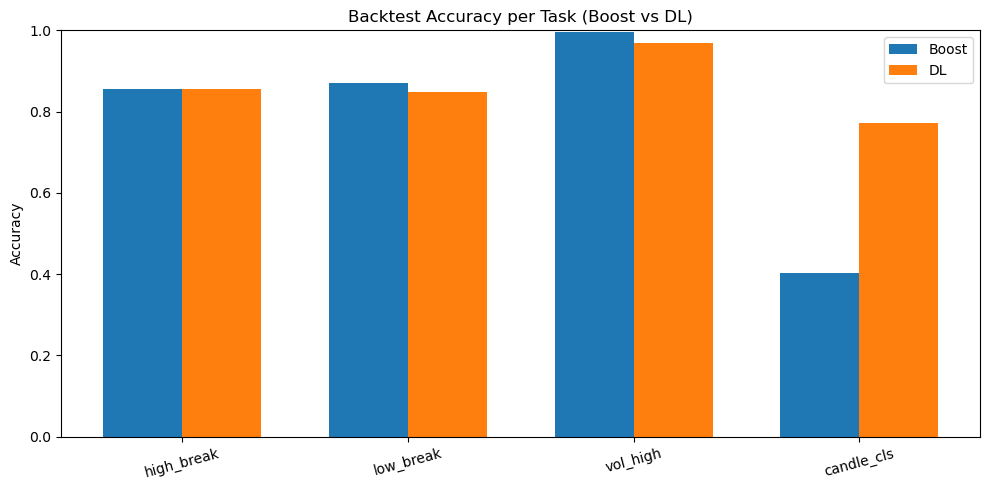

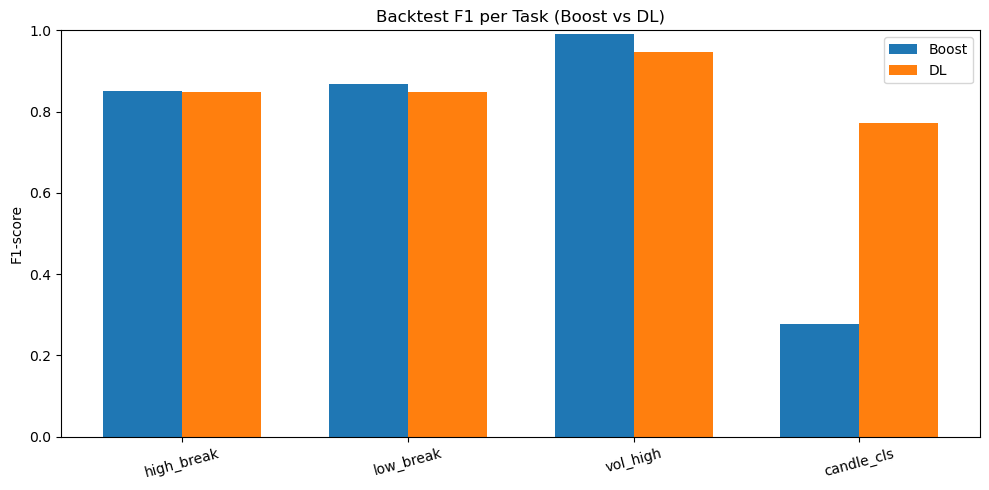

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# ==============================
# 1) สรุป Accuracy / F1 แล้วทำกราฟแท่ง
# ==============================


def cls_metrics(y_true, y_pred, multiclass=False):
    acc = accuracy_score(y_true, y_pred)
    if multiclass:
        f1 = f1_score(y_true, y_pred, average="macro")
    else:
        f1 = f1_score(y_true, y_pred)
    return acc, f1


# เก็บ metric ลง dict
results = []

# 1) Breakout High
acc_b, f1_b = cls_metrics(bt["tgt_high_break_true"], bt["boost_high_break_pred"])
acc_d, f1_d = cls_metrics(bt["tgt_high_break_true"], bt["dl_high_break_pred"])
results.append(("high_break", "Boost", acc_b, f1_b))
results.append(("high_break", "DL", acc_d, f1_d))

# 2) Breakout Low
acc_b, f1_b = cls_metrics(bt["tgt_low_break_true"], bt["boost_low_break_pred"])
acc_d, f1_d = cls_metrics(bt["tgt_low_break_true"], bt["dl_low_break_pred"])
results.append(("low_break", "Boost", acc_b, f1_b))
results.append(("low_break", "DL", acc_d, f1_d))

# 3) Volatility High
acc_b, f1_b = cls_metrics(bt["tgt_vol_high_true"], bt["boost_vol_high_pred"])
acc_d, f1_d = cls_metrics(bt["tgt_vol_high_true"], bt["dl_vol_high_pred"])
results.append(("vol_high", "Boost", acc_b, f1_b))
results.append(("vol_high", "DL", acc_d, f1_d))

# 4) Candle class (multiclass)
acc_b, f1_b = cls_metrics(
    bt["tgt_candle_true"], bt["boost_candle_pred"], multiclass=True
)
acc_d, f1_d = cls_metrics(bt["tgt_candle_true"], bt["dl_candle_pred"], multiclass=True)
results.append(("candle_cls", "Boost", acc_b, f1_b))
results.append(("candle_cls", "DL", acc_d, f1_d))

# แปลงเป็น DataFrame เพื่อ plot ง่าย ๆ
plot_df = pd.DataFrame(results, columns=["task", "model", "acc", "f1"])
print(plot_df)

# --- กราฟแท่ง: Accuracy ---
tasks = plot_df["task"].unique()
x = np.arange(len(tasks))
width = 0.35

acc_boost = [
    plot_df[(plot_df.task == t) & (plot_df.model == "Boost")]["acc"].values[0]
    for t in tasks
]
acc_dl = [
    plot_df[(plot_df.task == t) & (plot_df.model == "DL")]["acc"].values[0]
    for t in tasks
]

plt.figure(figsize=(10, 5))
plt.bar(x - width / 2, acc_boost, width, label="Boost")
plt.bar(x + width / 2, acc_dl, width, label="DL")

plt.xticks(x, tasks, rotation=15)
plt.ylim(0, 1.0)
plt.ylabel("Accuracy")
plt.title("Backtest Accuracy per Task (Boost vs DL)")
plt.legend()
plt.tight_layout()
plt.show()

# --- กราฟแท่ง: F1-score ---
f1_boost = [
    plot_df[(plot_df.task == t) & (plot_df.model == "Boost")]["f1"].values[0]
    for t in tasks
]
f1_dl = [
    plot_df[(plot_df.task == t) & (plot_df.model == "DL")]["f1"].values[0]
    for t in tasks
]

plt.figure(figsize=(10, 5))
plt.bar(x - width / 2, f1_boost, width, label="Boost")
plt.bar(x + width / 2, f1_dl, width, label="DL")

plt.xticks(x, tasks, rotation=15)
plt.ylim(0, 1.0)
plt.ylabel("F1-score")
plt.title("Backtest F1 per Task (Boost vs DL)")
plt.legend()
plt.tight_layout()
plt.show()

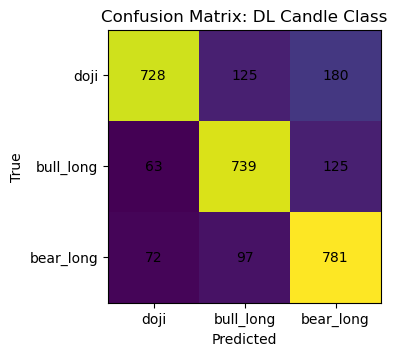

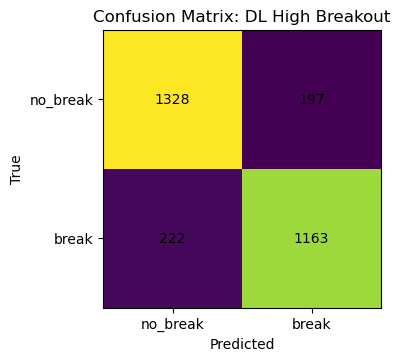

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def plot_confusion(task_name, y_true, y_pred, label_names=None):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm)

    ax.set_title(f"Confusion Matrix: {task_name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    if label_names is None:
        labels = np.arange(cm.shape[0])
        label_names = [str(l) for l in labels]
    else:
        labels = np.arange(len(label_names))

    ax.set_xticks(labels)
    ax.set_yticks(labels)
    ax.set_xticklabels(label_names)
    ax.set_yticklabels(label_names)

    # เขียนตัวเลขบนกรอบ
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                cm[i, j],
                ha="center",
                va="center",
            )

    fig.tight_layout()
    plt.show()


# ตัวอย่างใช้กับ candle (DL)
plot_confusion(
    "DL Candle Class",
    bt["tgt_candle_true"].values,
    bt["dl_candle_pred"].values,
    label_names=["doji", "bull_long", "bear_long"],
)

# จะใช้กับ breakout / vol ก็ได้ เช่น
plot_confusion(
    "DL High Breakout",
    bt["tgt_high_break_true"].values,
    bt["dl_high_break_pred"].values,
    label_names=["no_break", "break"],
)

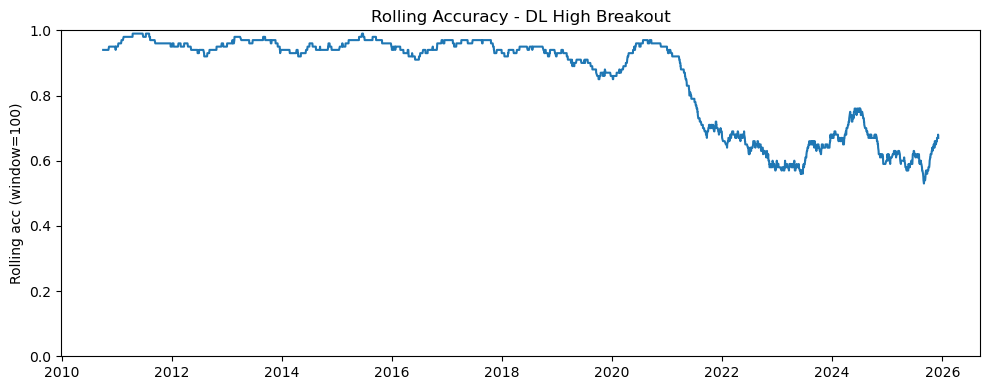

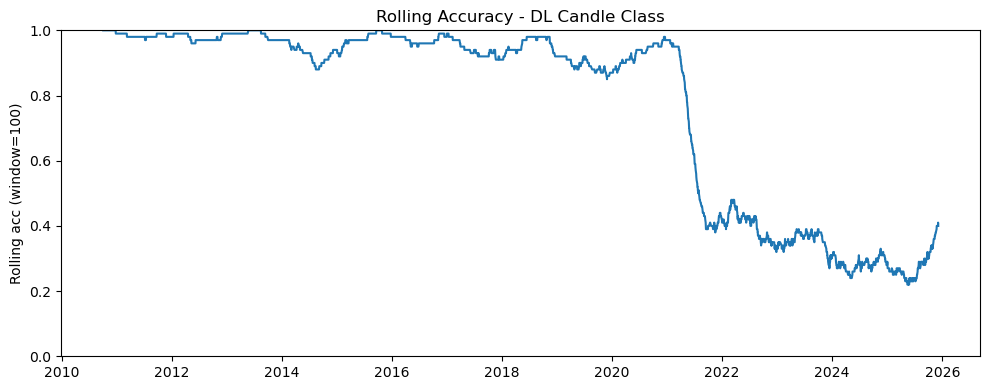

In [7]:
import matplotlib.pyplot as plt
import numpy as np


def plot_rolling_accuracy(
    bt,
    true_col: str,
    pred_col: str,
    window: int = 100,
    title: str = "",
):
    correct = (bt[true_col] == bt[pred_col]).astype(float)
    roll_acc = correct.rolling(window=window).mean()

    plt.figure(figsize=(10, 4))
    plt.plot(roll_acc.index, roll_acc.values)
    plt.ylim(0.0, 1.0)
    plt.ylabel(f"Rolling acc (window={window})")
    plt.title(title or f"Rolling Accuracy: {pred_col}")
    plt.tight_layout()
    plt.show()


# ตัวอย่าง: DL high breakout
plot_rolling_accuracy(
    bt,
    true_col="tgt_high_break_true",
    pred_col="dl_high_break_pred",
    window=100,
    title="Rolling Accuracy - DL High Breakout",
)

# ตัวอย่าง: DL candle class
plot_rolling_accuracy(
    bt,
    true_col="tgt_candle_true",
    pred_col="dl_candle_pred",
    window=100,
    title="Rolling Accuracy - DL Candle Class",
)